In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import imp
import sys
sys.path.append('/home/robin/Projects/INM6/elephant')
sys.path.append('/home/robin/Projects/INM6/python-neo')
from elephant.spike_train_surrogates import * 
from elephant.statistics import mean_firing_rate, cv, isi
import seaborn as sns
from quantities import Hz, ms
from scipy.linalg import eigh
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())
rc('text', usetex=True)
font_size = 24
text_size = 26

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

#### Load functions for validation tools and visualization

In [3]:
%%capture
dist = imp.load_source('*', './validation/dist.py')
matstat = imp.load_source('*', './validation/matrix.py')
testdata = imp.load_source('*', './validation/test_data.py')
vizi = imp.load_source('*', '../INM6/Tasks/viziphant/plots/generic.py')

path = '/home/robin/Projects/ValidationTools'

def fontsize(ax, size):
    for item in ([ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(size)
    for item in (ax.get_xticklabels()+ ax.get_yticklabels()):
        item.set_fontsize(size-4)
    return None

# Number of spiketrains:
N = 100

#### Load spiketrains from simulation

In [37]:
layer = ['spikes_L6']

data_path = path + '/sim_data'

spiketrains_nest = testdata.load_data(data_path + '/NEST_data', layer, N)[0]

spiketrains_spinnaker = testdata.load_data(data_path + '/SpiNNaker_data', layer, N)[0]

spiketrains_spinnaker2 = testdata.load_data(data_path + '/SpiNNaker_data_after_bugfix', layer, N)[0]

In [44]:
print spiketrains_nest[0][0].annotations

{'layer': 'L6', 'type': 'exc', 'object_ref': '9bc518723c2446a8b040128532288bda', 'id': 59847}


#### ...or generate custom spiketrains

(0.65371782148585622, 0.84708959004458262, 0.32827375098770734)
(0.9986312957370983, 0.85096502233954041, 0.18488274134841617)


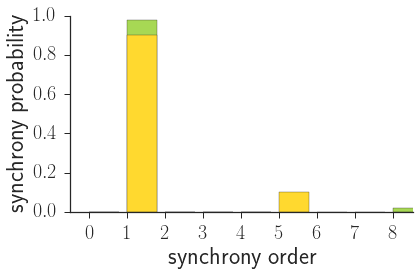

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
ax.bar(np.arange(9),[0, .98, 0, 0, 0, 0, 0, 0, 0.02], color=sns.color_palette('Set2')[4])
ax.bar(np.arange(6),[0, .9, 0, 0, 0, 0.1], color=sns.color_palette('Set2')[5])
# ax.bar([2],[0.05], color=sns.color_palette('Set2')[2], alpha=.5)
ax.set_xlim(-0.5,8.54)
ax.set_ylim(0, 1)
ax.set_xlabel('synchrony order')
ax.set_ylabel('synchrony probability')
ax.set_xticks(np.arange(9))
sns.despine()

print sns.color_palette()[4]
print sns.color_palette()[5]

fontsize(ax, font_size)
fig.tight_layout()
# plt.savefig('/home/robin/Sciebo/Poster/images/amplitude_dist.eps')

In [11]:
rate = 10*Hz
T = 10000*ms
binsize = 2.*ms
B = T/binsize
A_size = [8, 5]
sync_prob_assembly = [0.02, 0.1]

spiketrain_list_1 = testdata.test_data(size=N, 
                                       corr=sync_prob_assembly, 
                                       t_stop=T, 
                                       rate=rate, 
                                       assembly_sizes=A_size,
                                       method="CPP", 
                                       bkgr_corr=0.0)#,
                                       #shuffle=False)
                                       #shuffle_seed=42)

nbr_of_pairs = [size * (size-1) / 2 for size in A_size]
pw_synchrony = [testdata.transform_sync_prob(syprob, size, rate, T, B, A_size_1=2) 
                for syprob, size in zip(sync_prob_assembly, A_size)]
print pw_synchrony
print nbr_of_pairs
if 2*sum(nbr_of_pairs) > N:
    print "Warning: More than {} neurons needed for equivalence correlations".format(N)

spiketrain_list_2 = testdata.test_data(size=N, 
                                       corr=[pw_synchrony[0]] * nbr_of_pairs[0] 
                                          + [pw_synchrony[1]] * nbr_of_pairs[1], 
                                       t_stop=T, 
                                       rate=rate, 
                                       assembly_sizes=[2] * sum(nbr_of_pairs),
                                       method="CPP", 
                                       bkgr_corr=0.00,
                                       shuffle_seed=42)

for sts in spiketrain_list_1[:A_size[0]]:
    sts.annotations['assembly']='B'
for sts in spiketrain_list_1[A_size[0]:sum(A_size)]:
    sts.annotations['assembly']='A'
for sts in spiketrain_list_2:
    sts.annotations['assembly']='0'

[0.0794472387847948, 0.22056400443261706]
[28, 10]


#### Rasterplots

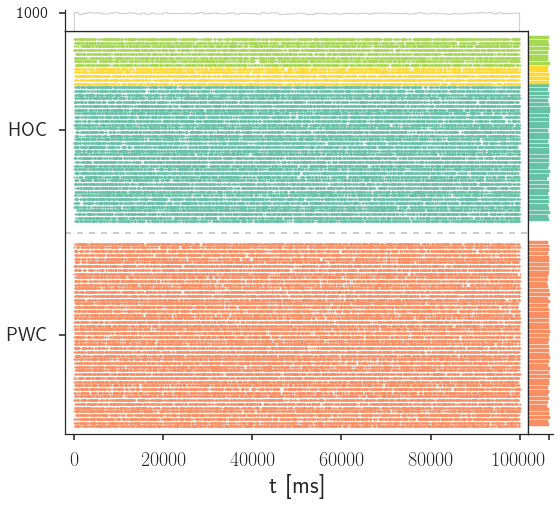

In [7]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
fig.tight_layout()

assembly_colors = [sns.color_palette()[1], sns.color_palette()[0], sns.color_palette()[5], sns.color_palette()[4]]

ax, axx, axy = vizi.rasterplot([spiketrain_list_2[:50], spiketrain_list_1[:50]], ax=ax, palette=assembly_colors, 
                     key_list=['assembly'], colorkey='assembly', pophist_mode='total', context='poster', 
                     groupingdepth=1, spacing=5, labelkey=0, histscale=0.05)
ax.set_yticklabels(['PWC', 'HOC'])
axy.set_xticklabels('')

fontsize(ax, font_size)
# plt.savefig('/home/robin/Sciebo/Poster/images/rasterplot_stochastic.eps')

In [14]:
from neo import SpikeTrain

def shift_to_0(spiketrains):
    t_lims = [(st.t_start, st.t_stop) for st in spiketrains]
    tmin = min(t_lims, key=lambda f: f[0])[0]
    tmax = max(t_lims, key=lambda f: f[1])[1]
    unit = spiketrains[0].units
    for count, spiketrain in enumerate(spiketrains):
        spiketrains[count] = SpikeTrain(
            np.array(spiketrain.tolist()) * unit - tmin,
            t_start=0 * unit,
            t_stop=tmax - tmin)
    return spiketrains

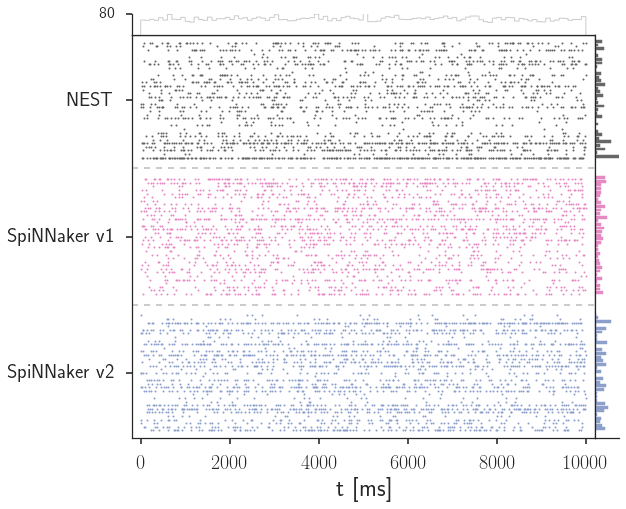

In [9]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
fig.tight_layout()

assembly_colors = [sns.color_palette()[2], sns.color_palette()[3], '.4']

ax, axx, axy = vizi.rasterplot([spiketrains_spinnaker2[1][:33], spiketrains_spinnaker[1][:33], shift_to_0(spiketrains_nest[1][:33])], 
                               ax=ax, palette=assembly_colors, colorkey=0, pophist_mode='total', context='poster', 
                     groupingdepth=1, spacing=5, labelkey=0, histscale=0.05)
# __ = vizi.rasterplot(spiketrain_list_2, ax=ax[1], palette=(['r']), context='talk')
# ax.set_xlim(0,10000)
ax.set_yticklabels(['SpiNNaker v2', 'SpiNNaker v1', 'NEST'])
axy.set_xticklabels('')

fontsize(ax, font_size)
# plt.savefig('/home/robin/Sciebo/Poster/images/rasterplot_microcircuit.eps')

### Compare distributions 
##### of CVs, firing rates, correlation coefficients, ...

In [15]:
def func(sts):
    ccs = matstat.corr_matrix(sts,  binsize=2*ms).flatten()   
    ccs = np.delete(ccs, np.where(ccs == 1)[0])
    return ccs
    
dist_HOC = func(spiketrain_list_1)

dist_PWC = func(spiketrain_list_2)

dist_nest = func(shift_to_0(spiketrains_nest[1]))
dist_spinnaker_v1 = func(spiketrains_spinnaker[1])
dist_spinnaker_v2 = func(spiketrains_spinnaker2[1])

#### Effect Size (Moment Matching)

In [ ]:
from numpy import mean, var
from scipy.stats import skew, kurtosis, moment

loggy=False
alt_var = (np.var(dist_sample_1) + np.var(dist_sample_2)) / 2.


print "Mean"
dist.effect_size(dist_sample_1, dist_sample_2, true_var=alt_var, comparison=mean, bias_correction=True, 
                 log_scale=loggy)
print "Variance"
dist.effect_size(dist_sample_1, dist_sample_2, true_var=None, comparison=var, bias_correction=True,
                 comparison_args={'ddof':1}, log_scale=loggy)
print "Skewness"
dist.effect_size(dist_sample_1, dist_sample_2, true_var=None, comparison=moment, bias_correction=True,
                 comparison_args={'moment':3}, dof=1, log_scale=loggy)
print "Kurtosis"
dist.effect_size(dist_sample_1, dist_sample_2, true_var=None, comparison=moment, bias_correction=True,
                 comparison_args={'moment':4}, dof=1, log_scale=loggy);
print "Tail Asymmetry"
dist.effect_size(dist_sample_1, dist_sample_2, true_var=None, comparison=moment, bias_correction=True,
                 comparison_args={'moment':5}, dof=1, log_scale=loggy);
print "Higher Tail Weights"
dist.effect_size(dist_sample_1, dist_sample_2, true_var=None, comparison=moment, bias_correction=True,
                 comparison_args={'moment':6}, dof=1, log_scale=loggy);

#### Bayesian Estimation

import best
import best.plot
from pymc import MCMC

model = best.make_model({'HOC':dist_HOC,'PWC':dist_PWC},
                        separate_nu=False)

M = MCMC(model)
M.sample(iter=110000, burn=10000)

best.plot.make_figure(M);

model = best.make_model({'NEST':dist_nest,'SpiNNaker v1':dist_spinnaker_v1},
                        separate_nu=False)

M_ns1 = MCMC(model)
M_ns1.sample(iter=110000, burn=10000)

model = best.make_model({'NEST':dist_nest,'SpiNNaker v2':dist_spinnaker_v2},
                        separate_nu=False)

M_ns2 = MCMC(model)
M_ns2.sample(iter=110000, burn=10000)

best.plot.make_figure(M_ns1)

best.plot.make_figure(M_ns2)

#### Show Distribution

In [ ]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,8))
fig.tight_layout()

# sns.set_palette()
_ = dist.show(dist_HOC, dist_PWC, bins=100, ax=ax)        
ax.legend(['HOC', 'PWC'])
ax.set_ylabel('Density')
ax.set_xlabel('Correlation Coefficient')
ax.set_ylim(0,2.5);

#### Kullback-Leibler Divergence

$$ D_\mathrm{KL}(P||Q) =\sum_{i} P(i) \log_2 \frac{P(i)}{Q(i)} = H(P,Q) - H(P)$$
$ $

The KL-Divergence is a measure of difference between two distribution based on entropy.

When $P$ can be regarded as reference, $D_\mathrm{KL}$ is the amount of information lost when substituting $Q$ for $P$. Consequently this measure is asymetric.

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
figsize=(8,6)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
sns.set_context('poster')
sns.set_palette('Set2')

DKL, DKL_inv = dist.KL_test(dist_HOC, dist_PWC, ax=ax, bins=150, mute=True, xlabel='Correlation Coefficient')

insaxes = inset_axes(ax, width="75%", height=2.5, loc=5)
_ = dist.KL_test(dist_HOC, dist_PWC, ax=insaxes, bins=150, mute=True, xlabel='')

insaxes.set_ylim(0,0.003)
insaxes.set_ylabel('')
sns.despine(ax=insaxes)

insaxes.text(.6, .5, r'$D_{KL}$ = ' + '{:.3f}'.format(DKL + DKL_inv), 
        fontsize=text_size, transform=ax.transAxes)

ax.legend(['HOC', 'PWC'], fontsize=font_size-4)
ax.set_ylabel('Density')

fontsize(ax, font_size)
fig.tight_layout()
# plt.savefig('/home/robin/Sciebo/Poster/images/DKL_stochastic.eps')

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True)
fig.tight_layout()
sns.set_palette('Set2')
binsize = 0.002

max_lim = max([max(dist_nest), max(dist_spinnaker_v1), max(dist_spinnaker_v2)])
min_lim = min([min(dist_nest), min(dist_spinnaker_v1), min(dist_spinnaker_v2)])
nbr_of_bins = np.ceil((max_lim - min_lim) / binsize)
edges = np.linspace(min_lim, max_lim, nbr_of_bins)

# NEST vs SpiNNaker v1

palette1 = ['.4', sns.color_palette()[3]]
DKL, DKL_inv = dist.KL_test(dist_nest, dist_spinnaker_v1, ax=ax[0], bins=edges,
                            mute=True, xlabel='', color=palette1)
ax[0].text(.4, .5, r'$D_{KL}$ = ' + '{:.3f}'.format(DKL + DKL_inv),
        fontsize=text_size-2, transform=ax[0].transAxes)

ax[0].set_xlim(-0.02,0.06)
ax[0].set_xticklabels(['-0.02','0.00','0.02','0.04', ''])
ax[0].legend(['NEST', 'SpiNNaker v1'], fontsize=font_size-6)
ax[0].set_ylabel('Density');

# NEST vs SpiNNaker v2

palette2 = ['.4', sns.color_palette()[2]]
DKL, DKL_inv = dist.KL_test(dist_nest, dist_spinnaker_v2, ax=ax[1], bins=edges,
                            mute=True, xlabel='', color=palette2)
ax[1].text(.4, .5, r'$D_{KL}$ = ' + '{:.3f}'.format(DKL + DKL_inv),
        fontsize=text_size-2, transform=ax[1].transAxes)
ax[1].set_xlim(-0.02,0.06)
ax[1].set_xticklabels(['','0.00','0.02','0.04', '0.06'])
ax[1].legend(['NEST', 'SpiNNaker v2'], loc=1, fontsize=font_size-6)
ax[1].set_ylabel('')

# Framing

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off', labelleft='off')
plt.xticks([.5],['A'], color='w', fontsize=font_size-4)
plt.xlabel('Correlation Coefficient', fontsize=font_size)

fontsize(ax[0], font_size)
fontsize(ax[1], font_size)
fig.tight_layout()

fig.subplots_adjust(wspace = 0)
# plt.savefig('/home/robin/Sciebo/Poster/images/DKL_simulation.eps')

#### Kolmogorov-Smirnov Distance

$$ D_\mathrm{KS} = \sup | \hat{P}(x) - \hat{Q}(x) | $$
$ $

The KS-Distance measures the maximal vertical distance of the cumulative distributions $\hat{P}$ and $\hat{Q}$. This is a sensitive tool for detecting differences in mean, variance or distribution type. But it can't well detect deviations in the tails of the distributions. A possibily more powerful alternative would be the Cramér-von-Mises Test.

$ $

The null hypothesis that the underlying distributions are identical is rejected when the $D_\mathrm{KS}$ statistic is larger than a critical value $D_\alpha$ or equivalently when the correponding p-value is less than the signficance level $\alpha$.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

DKS, p = dist.KS_test(dist_HOC, dist_PWC, ax=ax, mute=True)
ax.text(.5, .5, r'$D_{KS}$ = ' + '{:.3f}\n'.format(DKS) 
                    + r'$p$ = ' + '{}'.format(dist.to_precision(p,3)), 
                    fontsize=text_size, transform=ax.transAxes)
ax.legend(['HOC', 'PWC'], loc=4, fontsize=font_size-4)
ax.set_ylabel('Cumulative Density');
ax.set_xlabel('Correlation Coefficient')

fontsize(ax, font_size)
fig.tight_layout()

# plt.savefig('/home/robin/Sciebo/Poster/images/DKS_stochastic.eps')

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True)
# fig.tight_layout()
sns.set_palette('Set2')

# NEST vs SpiNNaker v1

palette1 = ['.4', sns.color_palette()[3]]
DKS, p = dist.KS_test(dist_nest, dist_spinnaker_v1, ax=ax[0], mute=True, xlabel='', color=palette1)
ax[0].text(.4, .5, r'$D_{KS}$ = ' + '{:.3f}\n'.format(DKS) 
                    + r'$p$ = ' + '{}'.format(dist.to_precision(p,3)), 
                    fontsize=text_size-2, transform=ax[0].transAxes)

ax[0].set_xlim(-0.02,0.06)
ax[0].set_xticklabels(['-0.02','0.00','0.02','0.04', ''])
ax[0].legend(['NEST', 'SpiNNaker v1'], loc=4, fontsize=font_size-6)
ax[0].set_ylabel('Cumulative Density');

# NEST vs SpiNNaker v2

palette2 = ['.4', sns.color_palette()[2]]
DKS, p = dist.KS_test(dist_nest, dist_spinnaker_v2, ax=ax[1], mute=True, xlabel='', color=palette2)
ax[1].text(.4, .5, r'$D_{KS}$ = ' + '{:.3f}\n'.format(DKS) 
                    + r'$p$ = ' + '{}'.format(dist.to_precision(p,3)), 
                    fontsize=text_size-2, transform=ax[1].transAxes)
ax[1].set_xlim(-0.02,0.06)
ax[1].set_xticklabels(['','0.00','0.02','0.04','0.06'])
ax[1].legend(['NEST', 'SpiNNaker v2'], loc=4, fontsize=font_size-4)
ax[1].set_ylabel('')

# Framing

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off', labelleft='off')
plt.xticks([.5],['A'], color='w', fontsize=font_size-6)
plt.xlabel('Correlation Coefficient', fontsize=font_size)

fontsize(ax[0], font_size)
fontsize(ax[1], font_size)
fig.tight_layout()
fig.subplots_adjust(wspace = 0)
# plt.savefig('/home/robin/Sciebo/Poster/images/DKS_simulation.eps')

#### Mann-Whitney U Test

$$ U_i = R_i - \frac{n_i(n_i + 1)}{2}\\ U = min(U_1,U_2) $$

$R_i$: rank sum

$n_i$: sample size

$ $

The Mann-Whitney U is a rank statistic which test the null hypothesis that a random value of sample 1 is equally likely to be larger or a smaller value than a randomly chosen value of sample 2.

$ $

The $U_i$ statistic is in the range of $[0,n_1 n_2]$, and the $U=min(U_1,U_2)$ statistic is in the range of $[0,\frac{n_1 n_2}{2}]$.

$ $

For sample sizes $>20$ $U$ follows approximately a normal distribution. With this assumption a p-value can be inferred. The null hypothesis is consequently rejected when the p-value is less than the significance level.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

U, p = dist.MWU_test(dist_HOC, dist_PWC, ax=ax, excl_nan=True, mute=True, 
                     sample_names=['HOC', 'PWC'])
print len(dist_HOC)
ax.text(.05, -.22, r'$U$ = ' + '{}\n'.format(dist.to_precision(U,3)) 
                      + r'$p$ = ' + '{}'.format(dist.to_precision(p,2)), 
                       fontsize=text_size, transform=ax.transAxes)
ax.set_xticks([])
ax.set_xticklabels([''])
ax.legend([], [], loc=9, ncol=2, handlelength=0.0, handletextpad=0.0, markerscale=0)
ax.text(.35, 1.01, 'HOC', fontsize=font_size, transform=ax.transAxes)
ax.text(.57, 1.01, 'PWC', fontsize=font_size, transform=ax.transAxes)

fontsize(ax, font_size)
ax.xaxis.label.set_fontsize=font_size-2
# fig.tight_layout()
# plt.savefig('/home/robin/Sciebo/Poster/images/MWU_stochastic.eps')

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True)
# fig.tight_layout()
sns.set_palette('Set2')

# NEST vs SpiNNaker v1

palette1 = ['.4', sns.color_palette()[3]]
U, p = dist.MWU_test(dist_nest, dist_spinnaker_v1, ax=ax[0], excl_nan=True, mute=True, 
                     sample_names=['NEST', 'SpiNNaker v1'], color=palette1)
ax[0].text(.05, -.22, r'$U$ = ' + '{}\n'.format(dist.to_precision(U,3)) 
                      + r'$p$ = ' + '{}'.format(dist.to_precision(p,2)), 
                       fontsize=text_size, transform=ax[0].transAxes)
ax[0].set_xticks([])
ax[0].set_xticklabels([''])
ax[0].legend([], [], loc=9, ncol=2, handlelength=0.0, handletextpad=0.0)
ax[0].set_ylabel('Rank')
ax[0].set_xlabel('')
ax[0].text(.22, 1.01, 'NEST', fontsize=font_size-2, transform=ax[0].transAxes)
ax[0].text(.53, 1.01, 'SpiNNaker v1', fontsize=font_size-2, transform=ax[0].transAxes)

# NEST vs SpiNNaker v2

palette2 = ['.4', sns.color_palette()[2]]
U, p = dist.MWU_test(dist_nest, dist_spinnaker_v2, ax=ax[1], excl_nan=True, mute=True, 
                     sample_names=['NEST', 'SpiNNaker v2'], color=palette2)
ax[1].text(.05, -.22, r'$U$ = ' + '{}\n'.format(dist.to_precision(U,3)) 
                  + r'$p$ = ' + '{}'.format(dist.to_precision(p,2)), 
                       fontsize=text_size, transform=ax[1].transAxes)
ax[1].set_xticks([])
ax[1].set_xticklabels([''])
ax[1].legend([], [], loc=9, ncol=2, handlelength=0.0, handletextpad=0.0, markerscale=0)
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].text(.22, 1.01, 'NEST', fontsize=font_size-2, transform=ax[1].transAxes)
ax[1].text(.53, 1.01, 'SpiNNaker v2', fontsize=font_size-2, transform=ax[1].transAxes)

# Framing

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off', labelbottom='off', labelleft='off')
plt.xlabel('Kernel Density Estimate', fontsize=font_size-2)

fontsize(ax[0], font_size)
fontsize(ax[1], font_size)
# fig.tight_layout()
fig.subplots_adjust(wspace = 0)

# plt.savefig('/home/robin/Sciebo/Poster/images/MWU_simulation.eps')

### Compare the correlation matrices

#### Heatmap

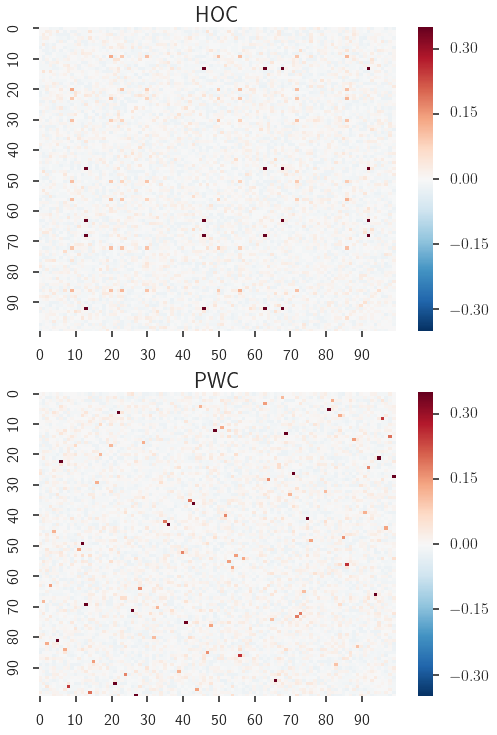

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,12))
# fig.tight_layout()

# np.random.shuffle(spiketrain_list_1)
corr_matrix_HOC = matstat.corr_matrix(spiketrain_list_1)
corr_matrix_PWC = matstat.corr_matrix(spiketrain_list_2)

vmin = -0.35
vmax = 0.35

ax[0].set_title('HOC', fontsize=font_size-2)
matstat.plot_matrix(corr_matrix_HOC, ax[0], remove_autocorr=True, vmin=vmin, vmax=vmax)
ax[1].set_title('PWC', fontsize=font_size-2)
matstat.plot_matrix(corr_matrix_PWC, ax[1], remove_autocorr=True, vmin=vmin, vmax=vmax)

# plt.savefig('/home/robin/Sciebo/Poster/images/ccmatrix_stochastic_pre.eps')

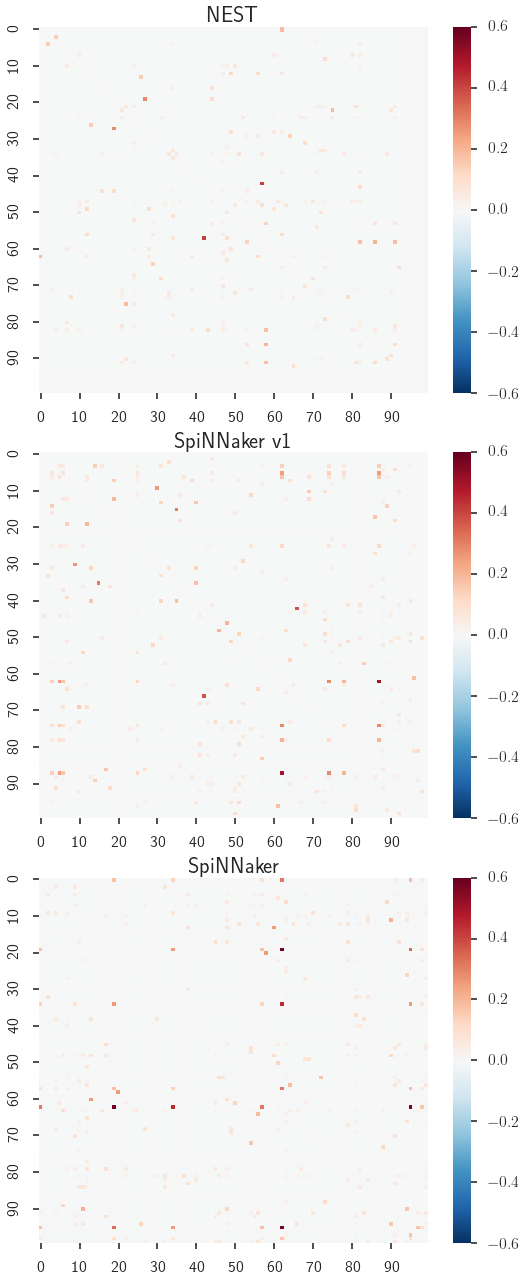

In [81]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,18))
fig.tight_layout()
sns.set_context('poster')

corr_matrix_nest = matstat.corr_matrix(shift_to_0(spiketrains_nest[0]))
corr_matrix_spinnaker_v1 = matstat.corr_matrix(spiketrains_spinnaker[0])
corr_matrix_spinnaker_v2 = matstat.corr_matrix(spiketrains_spinnaker2[0])

vmin = -0.1
vmax = 0.6

ax[0].set_title('NEST', fontsize=font_size-2)
matstat.plot_matrix(corr_matrix_nest, ax[0], remove_autocorr=True, vmin=vmin, vmax=vmax)
ax[1].set_title('SpiNNaker v1', fontsize=font_size-2)
matstat.plot_matrix(corr_matrix_spinnaker_v1, ax[1], remove_autocorr=True, vmin=vmin, vmax=vmax)
ax[2].set_title('SpiNNaker', fontsize=font_size-2)
matstat.plot_matrix(corr_matrix_spinnaker_v2, ax[2], remove_autocorr=True, vmin=vmin, vmax=vmax)
# plt.savefig('/home/robin/Sciebo/Poster/images/ccmatrix_simulation_pre.eps')

HOC
-0.0909290697973
0.0715568542957
PWC
0.253878773303
0.547954299368


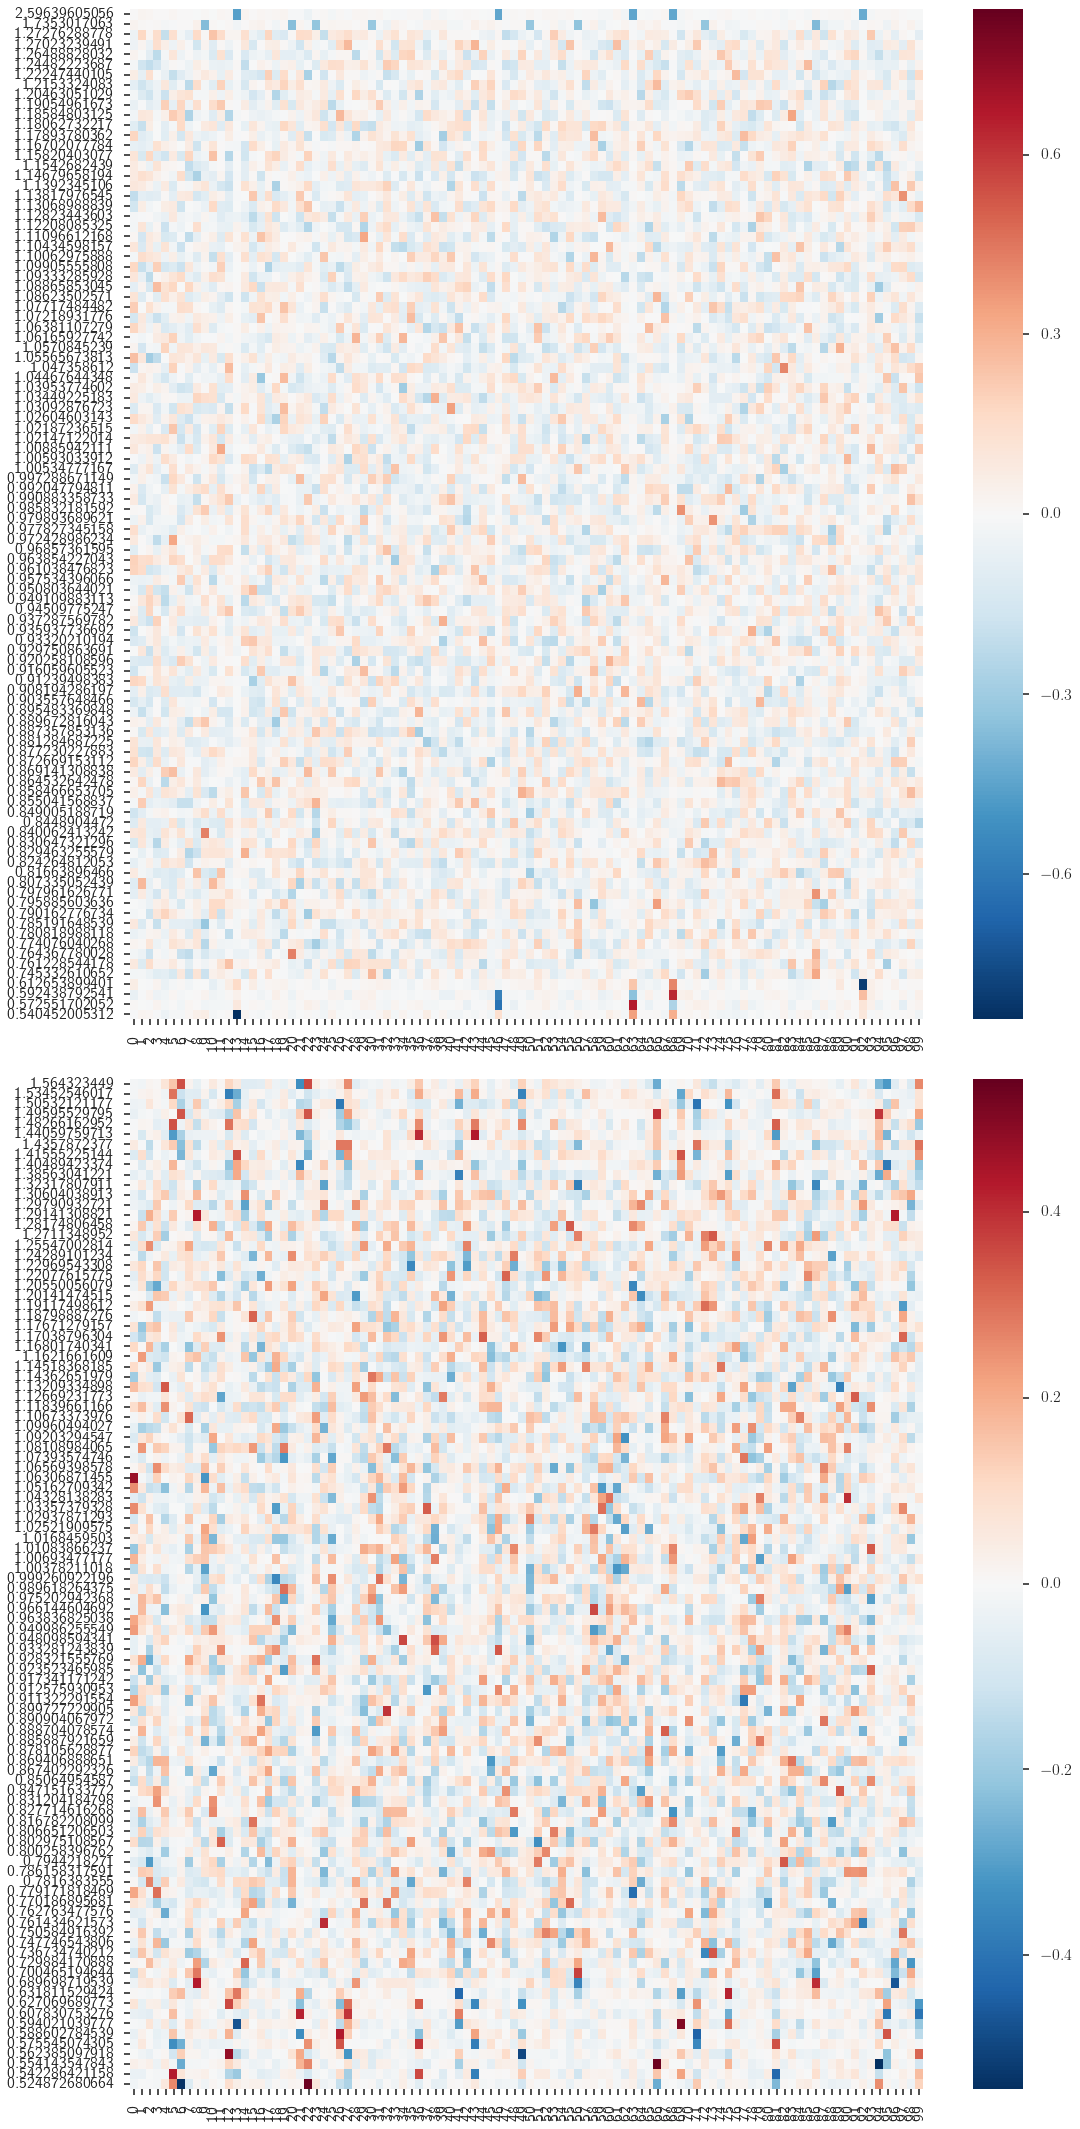

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,30))
fig.tight_layout()
sns.set_context('poster')

EWs_1, EVs_1 = eigh(corr_matrix_HOC)
sns.heatmap(EVs_1.T[::-1], ax=ax[0])
ax[0].set_yticklabels(EWs_1)
print 'HOC'
print np.corrcoef(np.absolute(EVs_1.T[-1]), np.absolute(EVs_1.T[-2]))[0,1]
print np.dot(np.absolute(EVs_1.T[-1]), np.absolute(EVs_1.T[-2]))

EWs_1, EVs_1 = eigh(corr_matrix_PWC)
sns.heatmap(EVs_1.T[::-1], ax=ax[1])
ax[1].set_yticklabels(EWs_1)
print 'PWC'
print np.corrcoef(np.absolute(EVs_1.T[-1]), np.absolute(EVs_1.T[-2]))[0,1]
print np.dot(np.absolute(EVs_1.T[-1]), np.absolute(EVs_1.T[-2]))

plt.show()

-0.304109775929
0.402703137509


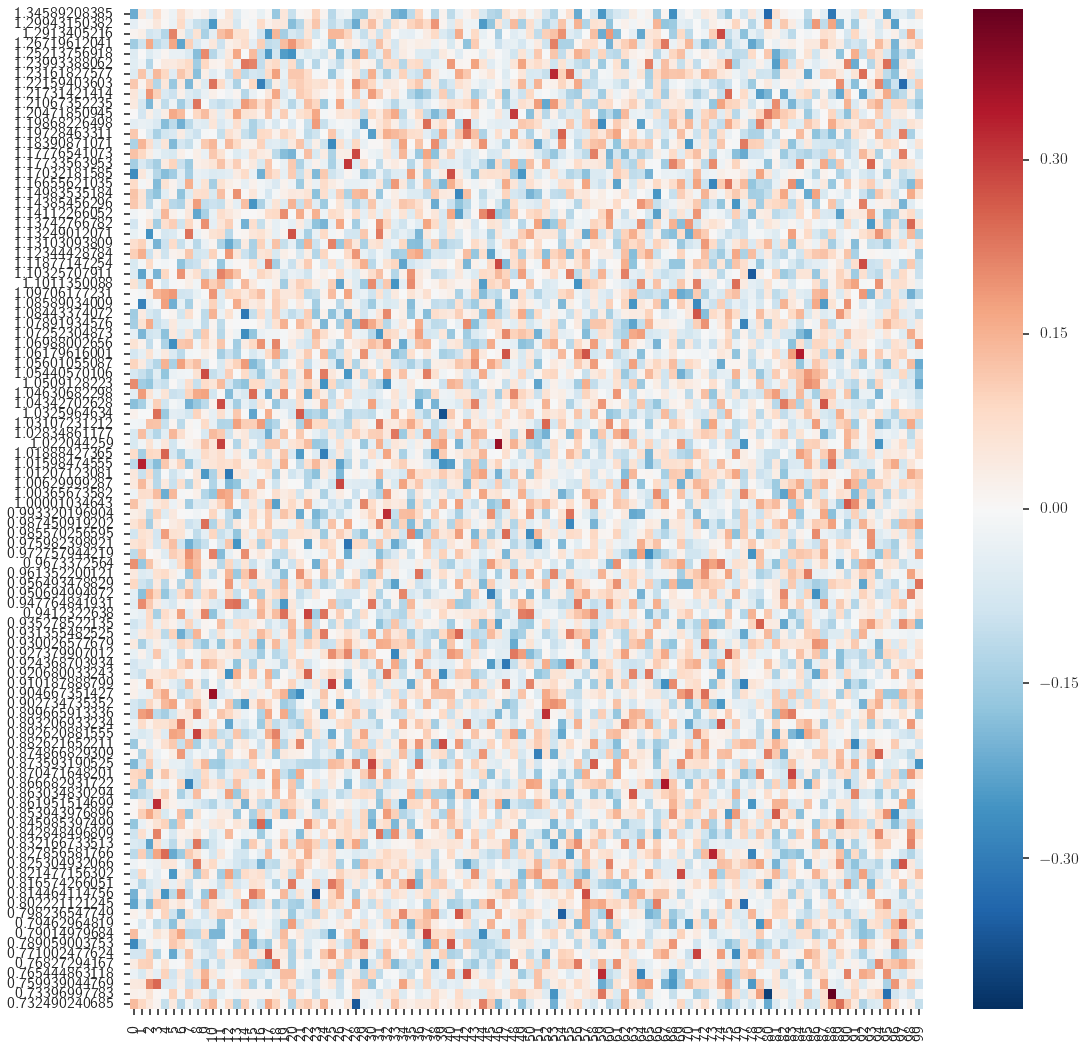

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
fig.tight_layout()
sns.set_context('poster')

EWs_1, EVs_1 = eigh(corr_matrix_nest)
sns.heatmap(EVs_1.T[::-1], ax=ax)
ax.set_yticklabels(EWs_1)


# print np.corrcoef(np.absolute(EVs_1.T[0]), np.absolute(EVs_1.T[1]))
dot = []
cc = []
for ev in EVs_1.T:
    for ev_ in EVs_1.T:
        dot += [np.dot(np.absolute(ev), np.absolute(ev_))]
        cc += [np.corrcoef(np.absolute(ev), np.absolute(ev_))[0,1]]
print min(cc)
print min(dot)


plt.show()

#### Eigenvalue distribution & spectra

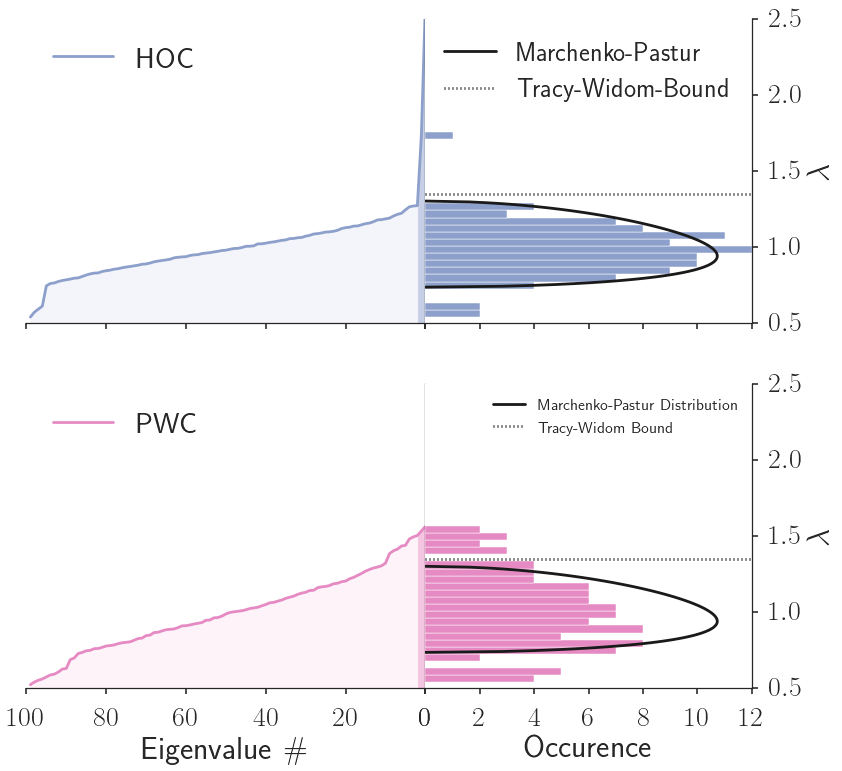

In [24]:
from matplotlib import rc
rc('text', usetex=True)

EWs_1, EVs_1 = eigh(corr_matrix_HOC)
EWs_2, EVs_2 = eigh(corr_matrix_PWC)

# sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(13,12), sharex=True)
# fig.tight_layout()
ymax = 2.5
ymin = 0.5

edges, axhist1, tw_bound1 = matstat.eigenvalue_significance(EWs_1, ax[0], bins=44, N=N, B=B, ylim=(ymin,ymax), 
                                     color=sns.color_palette()[0], mute=True)
xmax1 = axhist1.get_xlim()
ax[0].legend(['HOC'], loc=2, fontsize=font_size+6)
axhist1.legend(['Marchenko-Pastur', 'Tracy-Widom-Bound'], loc=1, fontsize=font_size+2)
axhist1.set_ylabel(r'$\lambda$', fontsize=font_size)
ax[0].set_xlabel('')
axhist1.set_xlabel('')
axhist1.set_xticklabels([])

__, axhist2, tw_bound2 = matstat.eigenvalue_significance(EWs_2, ax[1], bins=edges, N=N, B=B, ylim=(ymin,ymax), 
                                     color=sns.color_palette()[1], mute=True)
xmax2 = axhist2.get_xlim()
ax[1].legend(['PWC'], loc=2, fontsize=font_size+6)
# axhist2.legend(['Marchenko-Pastur', 'Tracy-Widom-Bound'], loc=1)
axhist2.set_ylabel(r'$\lambda$', fontsize=font_size+8)
ax[1].set_xlabel('Eigenvalue \#', fontsize=font_size)

axhist1.set_xlim((0,max(xmax1[1],xmax2[1])))
axhist2.set_xlim((0,max(xmax1[1],xmax2[1])))
fontsize(axhist1, font_size+8)
fontsize(ax[1], font_size+8)
fontsize(axhist2, font_size+8)
# plt.savefig('/home/robin/Sciebo/Poster/images/eigenvalues_stochastic.eps')

#### Show eigenvectors

In [ ]:
if N < 17:
    colormap = [37,37,30,34,32,31,33,36,35] + [47,40,44,42,41,43,46,45]
    matstat.print_eigenvectors(EVs_1, EWs_1, pc_nbr_1, colormap=colormap)
    matstat.print_eigenvectors(EVs_2, EWs_2, pc_nbr_2, colormap=colormap)

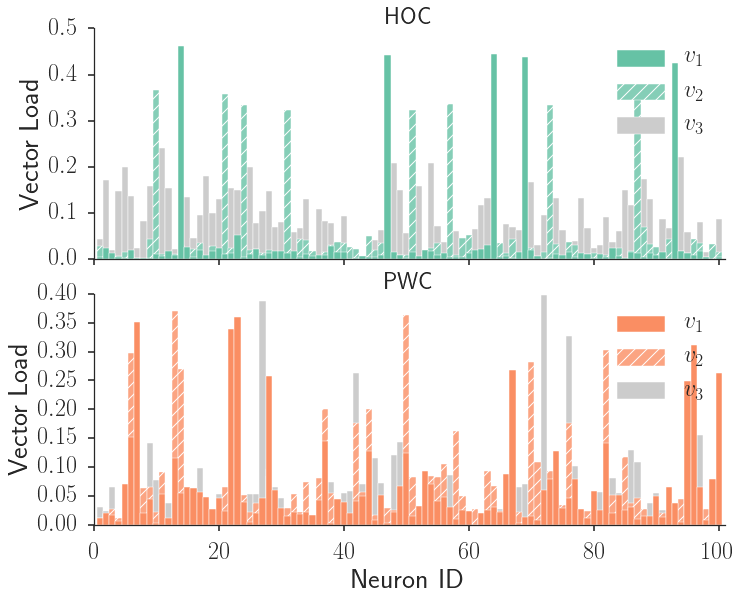

In [25]:
from matplotlib import rc
rc('text', usetex=True)

def plot_EVs(EVs, ax, color, hatch=None):
    if hatch is None:
        hatch = [''] * len(color)
    for i, _ in enumerate(color):
        i = len(color) - i - 1
        ax.bar(np.arange(100)+.5, np.absolute(EVs.T[::-1])[i], 1., edgecolor='w', 
                             label=r'$v_{}$'.format(i+1), color=color[i], hatch=hatch[i])
    ax.set_xlim(0,101)
    ax.set_ylabel('Vector Load')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], [r'$v_{}$'.format(j+1) for j in range(len(color))], fontsize=font_size)
    
EWs_1, EVs_1 = eigh(corr_matrix_HOC)
EWs_2, EVs_2 = eigh(corr_matrix_PWC)

sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)
fig.tight_layout()
palette = sns.color_palette()


def alpha(color_inst, a):
    return [el + (1.-el)*a for el in color_inst]

ax[0].set_title('HOC', fontsize=font_size)
plot_EVs(EVs_1, ax[0], [palette[0], alpha(palette[0],0.2), '0.8'], ['', '//', ''])
ax[1].set_title('PWC', fontsize=font_size)
plot_EVs(EVs_2, ax[1], [palette[1], alpha(palette[1],0.2), '0.8'], ['', '//', ''])
ax[1].set_xlabel('Neuron ID')

sns.despine()

fontsize(ax[0], font_size+4)
fontsize(ax[1], font_size+4)
# plt.savefig('/home/robin/Sciebo/Poster/images/eigenvectors_stochastic.eps')

In [26]:
print "\033[36mSample HOC\033[0m\n"
__, corr_order_HOC = matstat.detect_assemblies(EVs_1, EWs_1, detect_by=.3, EW_lim=tw_bound1, sort=True, jupyter=True)

print "\033[36mSample PWC\033[0m\n"
__, corr_order_PWC = matstat.detect_assemblies(EVs_2, EWs_2, detect_by=.3, EW_lim=tw_bound2, sort=True, jupyter=True)

Sample HOC

Assembly 1, eigenvalue 2.60, size 5
Neuron:	13	63	46	68	92		Norm
Load:	0.46	0.45	0.44	0.44	0.43		0.99

Assembly 2, eigenvalue 1.74, size 8
Neuron:	86	 9	20	56	23	72	50	30		Norm
Load:	0.37	0.37	0.36	0.34	0.33	0.33	0.32	0.32		0.97

Sample PWC

Assembly 1, eigenvalue 1.56, size 4
Neuron:	22	 6	21	95		Norm
Load:	0.36	0.35	0.34	0.31		0.68

Assembly 2, eigenvalue 1.53, size 3
Neuron:	12	49	81		Norm
Load:	0.37	0.36	0.30		0.60

Assembly 3, eigenvalue 1.51, size 3
Neuron:	71	26	75		Norm
Load:	0.40	0.39	0.33		0.65

Assembly 4, eigenvalue 1.50, size 4
Neuron:	66	94	22	 6		Norm
Load:	0.40	0.39	0.34	0.34		0.74

Assembly 5, eigenvalue 1.48, size 2
Neuron:	 5	81		Norm
Load:	0.35	0.33		0.48

Assembly 6, eigenvalue 1.44, size 4
Neuron:	43	36	81	 5		Norm
Load:	0.43	0.41	0.31	0.31		0.74

Assembly 7, eigenvalue 1.44, size 0
Neuron:		Norm
Load:		0.00

Assembly 8, eigenvalue 1.42, size 2
Neuron:	13	69		Norm
Load:	0.35	0.34		0.49

Assembly 9, eigenvalue 1.40, size 2
Neuron:	95	21		Norm
Load:	0.38

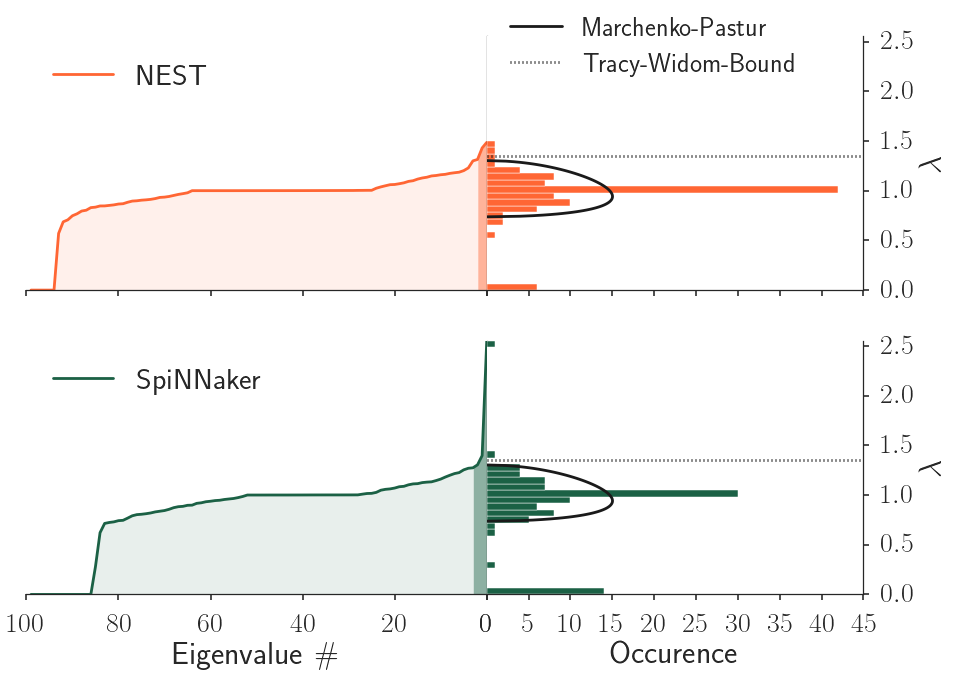

In [79]:
from matplotlib import rc
rc('text', usetex=True)
EWs_1, EVs_1 = eigh(corr_matrix_nest)
EWs_2, EVs_2 = eigh(corr_matrix_spinnaker_v1)
EWs_3, EVs_3 = eigh(corr_matrix_spinnaker_v2)

# sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(13,12), sharex=True)
# fig.tight_layout()
EW_max = max([max(EWs_3),max(EWs_2),max(EWs_1)])
EW_min = min([min(EWs_3),min(EWs_2),min(EWs_1)])
edges = np.linspace(EW_min, EW_max, 40)

ymax = EW_max
ymin = 0

_ , axhist1, tw_bound1 = matstat.eigenvalue_significance(EWs_1, ax[0], bins=edges, N=N, B=B, ylim=(ymin,ymax), 
                                     color=[0.4,0.4,0.4], mute=True)
xmax1 = axhist1.get_xlim()
ax[0].legend(['NEST'], loc=2, fontsize=font_size+6)
# plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode="expand", borderaxespad=0.)
axhist1.legend(['Marchenko-Pastur', 'Tracy-Widom-Bound'], bbox_to_anchor=(0., .75, 1., .1), loc=3, 
               fontsize=font_size+2)
axhist1.set_ylabel(r'$\lambda$')
ax[0].set_xlabel('')
axhist1.set_xlabel('')
axhist1.set_xticklabels([])

__, axhist2, tw_bound2 = matstat.eigenvalue_significance(EWs_2, ax[1], bins=edges, N=N, B=B, ylim=(ymin,ymax), 
                                     color=sns.color_palette()[3], mute=True)
xmax2 = axhist2.get_xlim()
ax[1].legend(['SpiNNaker v1'], loc=2, fontsize=font_size+6)
# axhist2.legend(['Marchenko-Pastur', 'Tracy-Widom-Bound'], loc=1)
axhist2.set_ylabel(r'$\lambda$')
ax[1].set_xlabel('')
axhist2.set_xlabel('')
axhist2.set_xticklabels([])


__, axhist3, tw_bound3 = matstat.eigenvalue_significance(EWs_3, ax[2], bins=edges, N=N, B=B, ylim=(ymin,ymax), 
                                     color=sns.color_palette()[2], mute=True)
xmax3 = axhist3.get_xlim()
ax[2].legend(['SpiNNaker v2'], loc=2, fontsize=font_size+6)
# axhist3.legend(['Marchenko-Pastur', 'Tracy-Widom-Bound'], loc=1)
axhist3.set_ylabel(r'$\lambda$')
ax[2].set_xlabel('Eigenvalue \#')

axhist1.set_xlim((0,max(xmax1[1],xmax2[1],xmax3[1])))
axhist2.set_xlim((0,max(xmax1[1],xmax2[1],xmax3[1])))
# plt.gcf().subplots_adjust(right=0.15)
fontsize(axhist1, font_size+8)
fontsize(ax[1], font_size+8)
fontsize(axhist2, font_size+8)
fontsize(ax[2], font_size+8)
fontsize(axhist3, font_size+8)
# plt.savefig('/home/robin/Sciebo/Poster/images/eigenvalues_simulation.eps')

In [ ]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,12), sharex=True)
fig.tight_layout()
palette = sns.color_palette()
from matplotlib import rc
rc('text', usetex=True)

ax[0].set_title('NEST', fontsize=font_size)
plot_EVs(EVs_1, ax[0], ['.4', alpha([0.4, 0.4, 0.4],0.2), '0.8'], ['', '//', ''])
# ax[0].legend([r'$v_1$', r'$v_2$', r'$v_3$'])

ax[1].set_title('SpiNNaker v1', fontsize=font_size)
plot_EVs(EVs_2, ax[1], [palette[3], alpha(palette[3],0.2), '0.8'], ['', '//', ''])
# ax[1].legend([r'$v_1$', r'$v_2$', r'$v_3$'])

ax[2].set_title('SpiNNaker v2', fontsize=font_size)
plot_EVs(EVs_3, ax[2], [palette[2], alpha(palette[2],0.2), '0.8'], ['', '//', ''])
# ax[2].legend([r'$v_1$', r'$v_2$', r'$v_3$'])
ax[2].set_xlabel('Neuron ID')

sns.despine()
fontsize(ax[0], font_size+4)
fontsize(ax[1], font_size+4)
fontsize(ax[2], font_size+4)
# plt.savefig('/home/robin/Sciebo/Poster/images/eigenvectors_simulation.eps')

In [59]:
print "\033[36mSample NEST\033[0m\n"
__, corr_order_nest = matstat.detect_assemblies(EVs_1, EWs_1, detect_by=.13, EW_lim=tw_bound1, sort=True, jupyter=True)

print "\033[36mSample SpiNNaker v1\033[0m\n"
__, corr_order_spinnaker_v1 = matstat.detect_assemblies(EVs_2, EWs_2, detect_by=.13, EW_lim=tw_bound2, sort=True, jupyter=True)

print "\033[36mSample SpiNNaker v2\033[0m\n"
__, corr_order_spinnaker_v2 = matstat.detect_assemblies(EVs_3, EWs_3, detect_by=.13, EW_lim=tw_bound3, sort=True, jupyter=True)

Sample NEST

Assembly 1, eigenvalue 1.49, size 5
Neuron:	58	86	91	82	53		Norm
Load:	0.57	0.44	0.43	0.37	0.34		0.98

Assembly 2, eigenvalue 1.43, size 4
Neuron:	57	42	48	34		Norm
Load:	0.70	0.66	0.19	0.14		0.99

Sample SpiNNaker v1

Assembly 1, eigenvalue 2.16, size 8
Neuron:	62	87	74	 5	78	 6	 3	25		Norm
Load:	0.52	0.52	0.37	0.33	0.28	0.24	0.21	0.18		1.00

Assembly 2, eigenvalue 1.40, size 5
Neuron:	35	40	15	13	31		Norm
Load:	0.57	0.50	0.45	0.31	0.30		0.98

Assembly 3, eigenvalue 1.38, size 2
Neuron:	66	42		Norm
Load:	0.70	0.70		0.99

Sample SpiNNaker v2

Assembly 1, eigenvalue 2.55, size 7
Neuron:	62	95	19	34	57	 0	98		Norm
Load:	0.56	0.44	0.44	0.36	0.27	0.27	0.15		1.00

Assembly 2, eigenvalue 1.40, size 6
Neuron:	90	48	11	94	60	13		Norm
Load:	0.51	0.43	0.41	0.39	0.27	0.25		0.95



#### Angles between eigenspaces

In [ ]:
# nbr_of_pcs = min(pc_nbr_1, pc_nbr_2)
nbr_of_pcs = 2
_ = matstat.EV_angles(EVs_1[:, -nbr_of_pcs:], EVs_2[:, -nbr_of_pcs:])

_ = matstat.EV_angles(EVs_1[:, -nbr_of_pcs:], EVs_3[:, -nbr_of_pcs:])

_ = matstat.EV_angles(EVs_2[:, -nbr_of_pcs:], EVs_3[:, -nbr_of_pcs:])

#### Show Assemblies in Correlation Matrix

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,12))
fig.tight_layout()

ordered_matrix_HOC = corr_matrix_HOC[corr_order_HOC, :][:, corr_order_HOC]
ordered_matrix_PWC = corr_matrix_PWC[corr_order_PWC, :][:, corr_order_PWC]

ax[0].set_title('HOC', fontsize=font_size)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

ax[1].set_title('PWC', fontsize=font_size)
matstat.plot_matrix(ordered_matrix_PWC, ax[1], labels=corr_order_PWC, remove_autocorr=True)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

# plt.savefig('/home/robin/Sciebo/Poster/images/ccmatrix_stochastic_post.eps')

[]

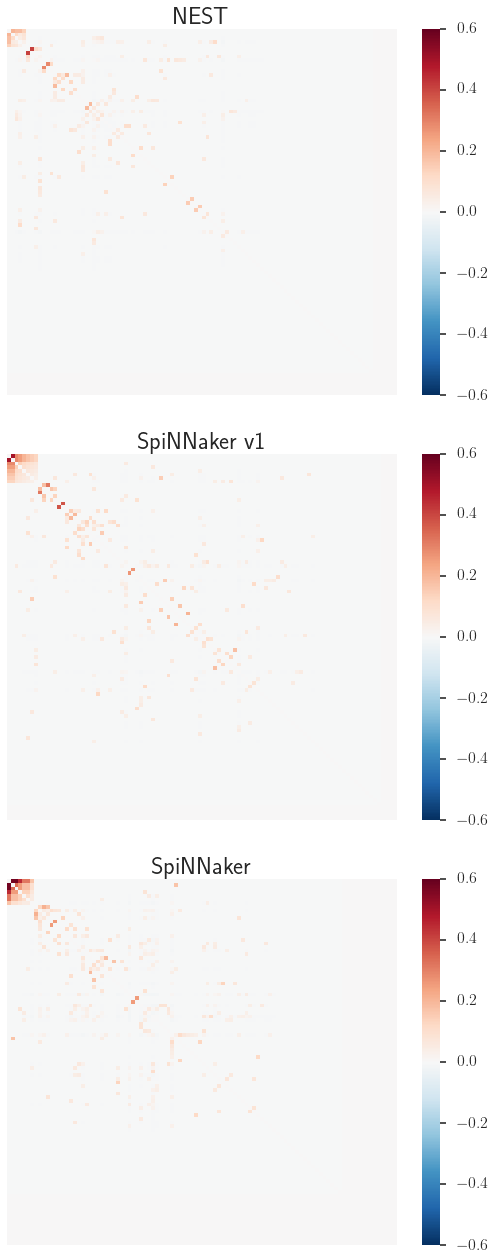

In [80]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,18))
fig.tight_layout()

ordered_matrix_nest = corr_matrix_nest[corr_order_nest, :][:, corr_order_nest]
ordered_matrix_spinnaker_v1 = corr_matrix_spinnaker_v1[corr_order_spinnaker_v1, :][:, corr_order_spinnaker_v1]
ordered_matrix_spinnaker_v2 = corr_matrix_spinnaker_v2[corr_order_spinnaker_v2, :][:, corr_order_spinnaker_v2]

vmin = -.1
vmax = .6

ax[0].set_title('NEST', fontsize=font_size)
matstat.plot_matrix(ordered_matrix_nest, ax[0], labels=corr_order_nest, remove_autocorr=True, vmin=vmin, vmax=vmax)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

ax[1].set_title('SpiNNaker v1', fontsize=font_size)
matstat.plot_matrix(ordered_matrix_spinnaker_v1, ax[1], labels=corr_order_spinnaker_v1, remove_autocorr=True, vmin=vmin, vmax=vmax)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

ax[2].set_title('SpiNNaker v2', fontsize=font_size)
matstat.plot_matrix(ordered_matrix_spinnaker_v2, ax[2], labels=corr_order_spinnaker_v2, remove_autocorr=True, vmin=vmin, vmax=vmax)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])

# plt.savefig('/home/robin/Sciebo/Poster/images/ccmatrix_simulation_post.eps')